In [2]:
import numpy as np
np.random.seed(42)
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from keras.models import Model
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D
from keras.preprocessing import text, sequence
from keras.callbacks import Callback, EarlyStopping

import pickle
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir('/content/gdrive/My Drive/comment')
from keras.layers import Embedding, Conv1D, Dropout, Dense, SpatialDropout1D, BatchNormalization, Activation
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D, MaxPooling1D, AveragePooling1D
from keras import optimizers, metrics, Model
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras import regularizers
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.layers import Concatenate, Input, Flatten
from keras.utils import plot_model
from sklearn.metrics import roc_curve,auc,roc_auc_score
from keras.callbacks import Callback
from keras import initializers
from tqdm import tqdm
import io

# 画图库
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sb
import matplotlib.pyplot as plt

Using TensorFlow backend.


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
# EMBEDDING_FILE = 'crawl-300d-2M.vec'

# train = pd.read_csv('train.csv')
# test = pd.read_csv('test.csv')
# submission = pd.read_csv('sample_submission.csv')
# X_train = train["comment_text"].fillna("fillna").values
# y_train = train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
# X_test = test["comment_text"].fillna("fillna").values

# max_features = 100000
# maxlen = 200
# embed_size = 300

# tokenizer = text.Tokenizer(num_words=max_features)
# tokenizer.fit_on_texts(list(X_train) + list(X_test))
# X_train = tokenizer.texts_to_sequences(X_train)
# X_test = tokenizer.texts_to_sequences(X_test)
# x_train = sequence.pad_sequences(X_train, maxlen=maxlen)
# x_test = sequence.pad_sequences(X_test, maxlen=maxlen)



# def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')
# embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in tqdm(open(EMBEDDING_FILE)))

# word_index = tokenizer.word_index
# nb_words = min(max_features, len(word_index))
# embedding_matrix = np.zeros((nb_words, embed_size))
# for word, i in tqdm(word_index.items()):
#     if i >= max_features: continue
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None: embedding_matrix[i] = embedding_vector

1999996it [03:16, 10160.76it/s]
100%|██████████| 394787/394787 [00:00<00:00, 841687.84it/s]


In [0]:
pickle.dump({'xtrain': x_train, 'xtest': x_test, 'em':embedding_matrix}, open('/content/gdrive/My Drive/comment/varibles.txt', 'wb'))

In [0]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
# pickle.dump({'strain': seq_train, 'stest': seq_test, 'fm':feature_matrix}, open('/content/gdrive/My Drive/comment/var.txt', 'wb'))
var = pickle.load(open('/content/gdrive/My Drive/comment/varibles.txt', 'rb'))
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
x_train = var['xtrain']
x_test = var['xtest']
embedding_matrix = var['em']
y_train = train_data[labels].values

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 200, 300)     30000000    input_9[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_9 (SpatialDro (None, 200, 300)     0           embedding_9[0][0]                
__________________________________________________________________________________________________
conv1d_25 (Conv1D)              (None, 200, 64)      19264       spatial_dropout1d_9[0][0]        
__________________________________________________________________________________________________
conv1d_26 

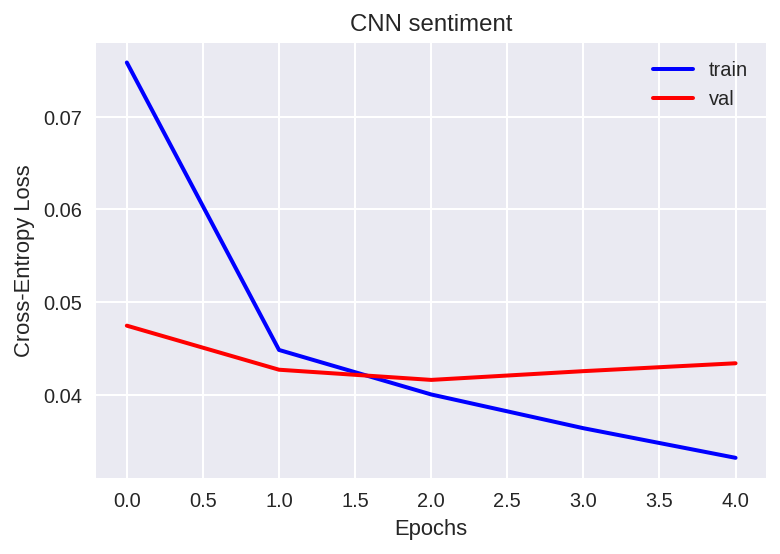

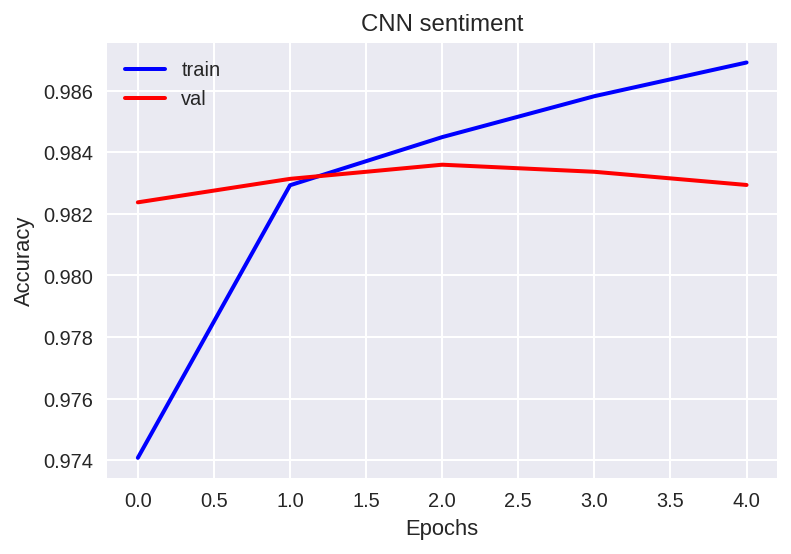

In [14]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))



max_features = 100000
embed_size = 300
maxlen = 200

num_filters = 64
filter_sizes = [1,2,3]

inp = Input(shape=(maxlen, ))
x = Embedding(max_features, 
              embed_size,  
              input_length = maxlen,
              weights=[embedding_matrix],
              trainable=True)(inp)

x = SpatialDropout1D(0.5)(x)

conv_0 = Conv1D(num_filters, filter_sizes[0], 
                kernel_initializer=initializers.RandomNormal()
               )(x)
conv_1 = Conv1D(num_filters, 
                filter_sizes[1], 
                kernel_initializer=initializers.RandomNormal()
               )(x)
conv_2 = Conv1D(num_filters, 
                filter_sizes[2], 
                kernel_initializer=initializers.RandomNormal()
               )(x)

ac_0 = PReLU()(conv_0)
ac_1 = PReLU()(conv_1)
ac_2 = PReLU()(conv_2)

maxpool_0 = MaxPooling1D(pool_size=(maxlen - filter_sizes[0] + 1))(ac_0)
maxpool_1 = MaxPooling1D(pool_size=(maxlen - filter_sizes[1] + 1))(ac_1)
maxpool_2 = MaxPooling1D(pool_size=(maxlen - filter_sizes[2] + 1))(ac_2)

z = Concatenate(axis=1)([maxpool_0,
                         maxpool_1,
                         maxpool_2
                        ])
z = Flatten()(z)

# fc = Dense(32, 
#            kernel_initializer=initializers.RandomNormal(),
#            activation='elu')(z)
fc = Dense(6, 
           kernel_initializer=initializers.RandomNormal(),
           activation='sigmoid')(z)

model = Model(inp, fc)
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])


model.summary()

batch_size = 256
epochs = 10

X_tra, X_val, y_tra, y_val = train_test_split(x_train, y_train, 
                                              test_size=0.1, shuffle=True)

RocAuc = RocAucEvaluation(validation_data=(X_val, y_val), interval=1)

early = EarlyStopping(monitor='val_acc', 
                      min_delta=0.01, 
                      patience=4, 
                      verbose=1)

callback_list = [RocAuc, early]

hist = model.fit(X_tra, y_tra, 
                 batch_size=batch_size, 
                 epochs=epochs, 
                 validation_data=(X_val, y_val),
                 callbacks=callback_list, 
                 verbose=1,
                 shuffle=True,
                 class_weight='balanced')


plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

plt.figure()
plt.plot(hist.history['acc'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_acc'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

y_pred = model.predict(x_test, batch_size=1024)
submission = pd.read_csv('sample_submission.csv')
submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred
submission.to_csv('CNN.csv', index=False)